In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import tensorflow as tf
import time

from sklearn.metrics import confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [83]:
try:
  data = pd.read_csv('Structured_features.csv')
except:
  print('No such file')

In [84]:
# encode the erbium concentration float value to int
uniq_concent = data["Erbium Concentration"].unique().tolist()
conc_encoded = {x: i for i, x in enumerate(uniq_concent)}

# for later decode use
encoded_to_conc = {i: x for i, x in enumerate(uniq_concent)}
encoded_to_conc

data["Erbium Concentration"] = data["Erbium Concentration"].map(conc_encoded)
data

,Longitudinal modulus,Shear modulus,Bulk modulus,Young modulus,Poisson's ratio,Hardness,fractal bond connectivity,acoustic impedance,Erbium Concentration
0,60.505571,20.125896,33.671042,50.346610,0.250792,3.343693,2.390885,17.829646,0
1,61.749309,20.539600,34.363176,51.381524,0.250792,3.412425,2.390885,18.196148,0
2,60.206152,20.026301,33.504417,50.097465,0.250792,3.327146,2.390885,17.741414,0
3,62.014179,20.627703,34.510575,51.601922,0.250792,3.427063,2.390885,18.274199,0
4,62.831822,20.899675,34.965589,52.282281,0.250792,3.472248,2.390885,18.515140,0
...,...,...,...,...,...,...,...,...,...
245,58.273308,19.835527,31.825938,49.270607,0.241979,3.411991,2.493001,17.663388,4
246,57.141365,19.450228,31.207728,48.313539,0.241979,3.345714,2.493001,17.320282,4
247,61.777979,21.028475,33.740012,52.233838,0.241979,3.617195,2.493001,18.725699,4
248,58.251540,19.828118,31.814050,49.252202,0.241979,3.410717,2.493001,17.656790,4


In [85]:
column_name = data.columns[:-1]
column_name

Index(['Longitudinal modulus', 'Shear modulus', 'Bulk modulus',
       'Young modulus', 'Poisson's ratio', 'Hardness',
       'fractal bond connectivity', 'acoustic impedance'],
      dtype='object')

In [40]:
for column in column_name:
    data[column] = (data[column] - data[column].min()) / (data[column].max() - data[column].min())

In [41]:
data

,Longitudinal modulus,Shear modulus,Bulk modulus,Young modulus,Poisson's ratio,Hardness,fractal bond connectivity,acoustic impedance,Erbium Concentration
0,0.402600,0.447432,0.450173,0.422583,0.643648,0.426756,0.282833,0.383823,0
1,0.450058,0.500519,0.486700,0.477551,0.643648,0.460885,0.282833,0.436787,0
2,0.391175,0.434652,0.441379,0.409349,0.643648,0.418540,0.282833,0.371072,0
3,0.460165,0.511824,0.494479,0.489257,0.643648,0.468153,0.282833,0.448067,0
4,0.491364,0.546724,0.518492,0.525394,0.643648,0.490590,0.282833,0.482886,0
...,...,...,...,...,...,...,...,...,...
245,0.317422,0.410172,0.352798,0.365432,0.556935,0.460670,0.354152,0.359796,4
246,0.274230,0.360730,0.320173,0.314598,0.556935,0.427760,0.354152,0.310213,4
247,0.451152,0.563252,0.453813,0.522821,0.556935,0.562564,0.354152,0.513314,4
248,0.316592,0.409221,0.352171,0.364454,0.556935,0.460037,0.354152,0.358843,4


In [42]:
train_dataset = data.sample(frac=0.8, random_state=0)
test_dataset = data.drop(train_dataset.index)

# Collect input feature for training, molar volume value in this case
train_features = train_dataset.copy() #dataframe type
test_features = test_dataset.copy()

# Collect respective label, density value in this case
train_labels = train_features.pop('Erbium Concentration') # series type
test_labels = test_features.pop('Erbium Concentration')

In [56]:
for i in range(10):  
  sgd_classifier = SGDClassifier(
                                max_iter=300,
                                learning_rate='constant',
                                loss='squared_hinge',
                                validation_fraction=0.2,
                                early_stopping=True,
                                eta0=0.001,
                                ).fit(train_features, train_labels)

  pred_y = sgd_classifier.predict(test_features)
  train_acc = sgd_classifier.score(train_features, train_labels)
  test_acc = sgd_classifier.score(test_features, test_labels)

  print('Training Accuracy : %.3f'%train_acc)
  print('Test Accuracy : %.3f'%test_acc)

Training Accuracy : 0.340
Test Accuracy : 0.240
Training Accuracy : 0.360
Test Accuracy : 0.260
Training Accuracy : 0.370
Test Accuracy : 0.220
Training Accuracy : 0.340
Test Accuracy : 0.240
Training Accuracy : 0.335
Test Accuracy : 0.240
Training Accuracy : 0.335
Test Accuracy : 0.200
Training Accuracy : 0.375
Test Accuracy : 0.260
Training Accuracy : 0.245
Test Accuracy : 0.160
Training Accuracy : 0.340
Test Accuracy : 0.240
Training Accuracy : 0.345
Test Accuracy : 0.240


In [57]:
y_true, y_pred = test_labels , sgd_classifier.predict(test_features)

print('Results on the test set:')
print(classification_report(y_true, y_pred))

Results on the test set:
              precision    recall  f1-score   support

           0       0.28      0.62      0.38         8
           1       0.00      0.00      0.00        11
           2       0.22      0.88      0.35         8
           3       0.00      0.00      0.00        11
           4       0.00      0.00      0.00        12

    accuracy                           0.24        50
   macro avg       0.10      0.30      0.15        50
weighted avg       0.08      0.24      0.12        50



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy score : 0.24


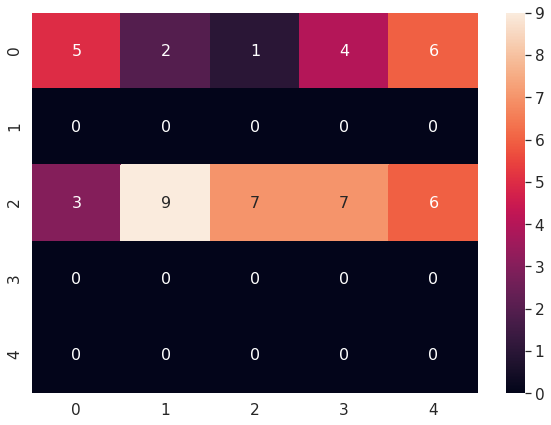

In [58]:
def accuracy(confusion_matrix):
   diagonal_sum = confusion_matrix.trace()
   sum_of_all_elements = confusion_matrix.sum()
   return diagonal_sum / sum_of_all_elements

plt.figure(figsize=(10,7))
cm = confusion_matrix(pred_y, test_labels)
print("Accuracy score :", accuracy(cm))
sns.set(font_scale=1.4) # for label size
sns.heatmap(cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

# **Feature Selection**

In [86]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

num_select = 5
X = data[column_name]
y = data['Erbium Concentration']
selected_features = SelectKBest(score_func=chi2, k=num_select)
fit = selected_features.fit(X,y)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(num_select,'Score'))

                  Specs     Score
2          Bulk modulus  6.292307
0  Longitudinal modulus  5.062600
3         Young modulus  2.813917
1         Shear modulus  1.140136
7    acoustic impedance  0.958431


[0.07414524 0.06647425 0.08991401 0.06804037 0.26560992 0.1078021
 0.2477781  0.08023601]


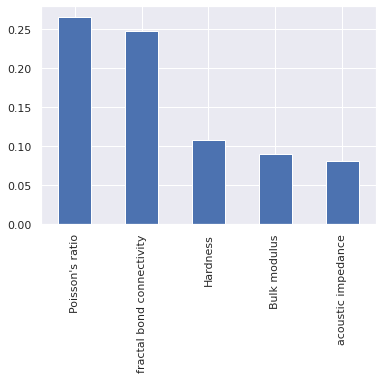

In [87]:
from sklearn.ensemble import ExtraTreesClassifier

extract_tree = ExtraTreesClassifier()
extract_tree.fit(X,y)

print(extract_tree.feature_importances_)
feat_importances = pd.Series(extract_tree.feature_importances_, index=X.columns)
feat_importances.nlargest(num_select).plot(kind='bar')
plt.show()

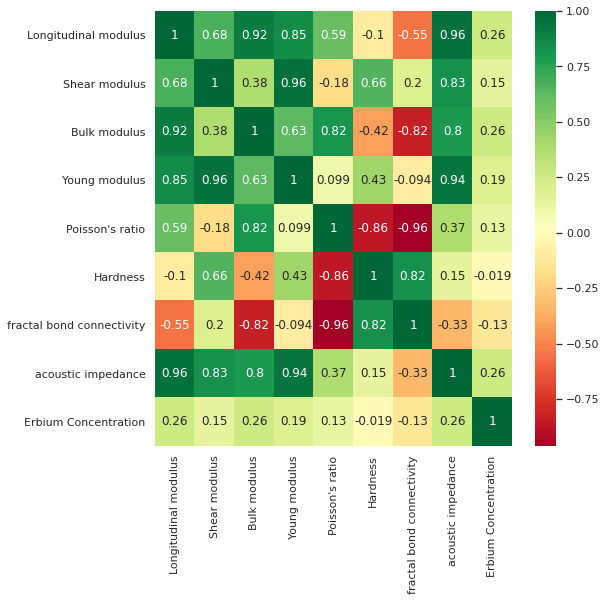

In [88]:
corrmat = data.corr()
top_corr_features = corrmat.index
sns.set(font_scale=1.0)
plt.figure(figsize=(8,8))
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")